# 1 - Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv("bci05.csv")
data.head()

,tag,sp,gx,gy,dbh,pom,date,codes,status
0,105951,ACACME,610.0,104.7,119.0,1,8924.0,M,A
1,132160,ACACME,534.8,241.3,116.0,1,8922.0,*,A
2,132234,ACACME,539.4,242.3,NaN,0,8922.0,DN,D
3,132235,ACACME,538.8,242.5,NaN,0,8922.0,DN,D
4,191542,ACACME,282.7,177.5,75.0,1,8825.0,*,A


In [3]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [4]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

There are 299 different species


# 2 - Statistics on subplots

Now we divide the total area of study (sampled plot) in 200 subplots of the same area.
To do so we add two columns to the dataset, called $i$ and $j$, that are the result of division without rest respectively of $gx$ and $gy$ for 50 (0.5 hectars in each axis). Then we use some methods of pandas to encode in a 3D matrix the aboundance $x_k$ of each of the S species for each subplot $(i,j)$ and from that we can obtain the average presence of each species.

In [5]:
# 2) Subsampling
# 50 * 50 meters
data["i"], data["j"] = data["gx"]//50, data["gy"]//50
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(20, 10, 299) # (i, j, specie)


# this prints are just for understanding how to work with this dataset
#print("Presence and aboundance in subplot (0,0) : \n", cell_pop_M[0,0,:], '\n')
#print("Aboundances of the various species: \n", cell_pop_M.sum(axis=(0,1)), '\n')

p_i = np.count_nonzero(cell_pop_M, axis = (0,1))/200
#print("Absolute presence for each species: \n", presence, '\n')
#print("Relative presence for each species: \n", p_i, '\n')

And the average squared difference between present and absent species in a subplot (that will be used as a constraint in section 4):

In [28]:
def pairing_p(configs):
    # In each subplot there are more absent species than present (just an observation)
    # S+ - S-
    S_present = np.count_nonzero(configs, axis = (1)).flatten()
    # S_absent = S - S_present -> S_pm = 2*S_present - S
    S_pm = 2*S_present - S # Broadcasting
    # constraint C_0 = < (S+ - S-)^2 >
    return np.mean(np.power(S_pm,2))


C_0_over_S = pairing_p(cell_pop_M.reshape(200, 299))/299
print(C_0_over_S)

21.32829431438127


## 3 - Max Ent 1

### Hamiltonian of the system for our constraints.

We start considering a generic entropy:

$$ S[\{p_a\}_{i=1,\ldots,n}] = -K \sum_{a=1}^n p_a ln(p_a), K > 0$$

and following constraints:

$$ \sum_{a=1}^n p_a - 1 = 0 $$

$$\sum_{a=1}^n  p_a f_r(x_a) - <f_r(x)>_{obs} = 0 $$

On the PDF we show that the corresponding Hamiltonian is:

$$H(x_a, \vec{\lambda}) = - \sum_{r=1}^{m}\lambda_i f_i(x_a)$$


### Analytical derivation of the tuned Lagrangian multipliers as functions of the constraints.

Adopting the notation to our specific model, we set $K=1$, and rename:

$x_a \rightarrow \vec{\sigma^{(a)}}, m \rightarrow S, f_r(x) \rightarrow \pi_i(\vec{\sigma}) = \sigma_i$

We start considering the following Hamiltonian:

$H(\vec{\sigma}, \vec{\lambda}) = - \sum_{i=1}^{S}\lambda_i f_i(\sigma) = - \sum_{i=1}^{S}\lambda_i \sigma_i $

Manipulating the partition function

$$Z(\vec{\lambda}) = \sum_{\{\vec{\sigma}\}} \exp\{\sum_{i=1}^S \lambda_i \sigma_i\} = \
    \sum_{\{\vec{\sigma}\}} \prod_{i=1}^S\exp\{\lambda_i \sigma_i\} = \
    \prod_{i=1}^S \sum_{\sigma_i = \pm 1} \exp\{\lambda_i \sigma_i\}  = \
    2^S \prod_{i=1}^S \cosh(\lambda_i)$$

Hence we can compute analytically the expected value for each variable $\sigma_i$ for a given value of $\vec{\lambda}$

$$ <\sigma_i>_{model(\vec{\lambda})} = \sum_{\{\vec{\sigma}\}} \sigma_i P(\vec{\sigma}/\vec{\lambda}) = \
\frac{\sum_{\sigma_i \pm 1} \sigma_i e^{\lambda_i \sigma_i}}{2 cosh(\lambda_i)} = tanh(\lambda_i) $$

Now we impose $\forall i$ $m_i = <\sigma_i>_{model(\vec{\lambda})}$ 

$m_i = tanh(\lambda_i) $

and inverting the system we find

$ \lambda_i = tanh^{-1}(m_i) = \frac{1}{2} \cdot ln(\frac{1 + m_i}{1 - m_i} )$

Here we apply the formula just obtained to compute the lagrangian parameters for the model Max Ent 1

In [29]:
m_i = 2*p_i - 1
print(m_i.max(), m_i.min())
# PROBLEM: too much variance depending on epsilon...
eps = 0
l_i = np.arctanh(m_i- np.sign(m_i)*eps) # same function
print(l_i.max(),l_i.min())

1.0 -0.99
inf -2.6466524123622457


/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in arctanh
  """


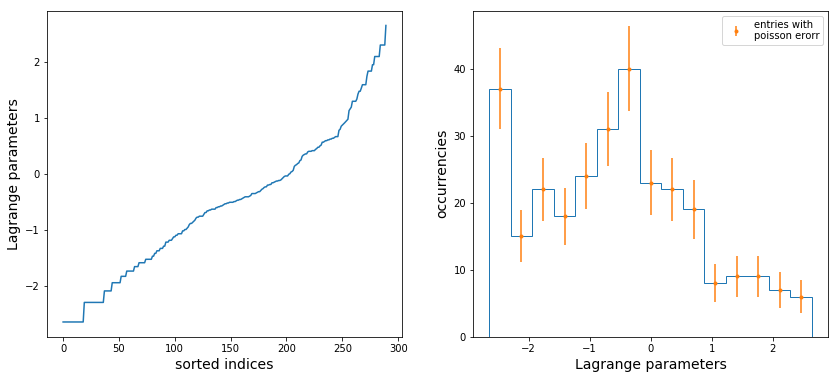

In [30]:
# first we remove from the plots the infinite eigenvalues
l_i_sorted = l_i[np.isfinite(l_i)]
# then we sort the remaining one for the first plot
l_i_sorted.sort()

fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
# left panel
ax[0].plot(l_i_sorted)
ax[0].set_xlabel("sorted indices", fontsize = 14)
ax[0].set_ylabel("Lagrange parameters", fontsize = 14)
# right panel
counts, bin_extremes1, _ = ax[1].hist(l_i_sorted, bins = 15, histtype = 'step', density = False)
bin_centers1 = (bin_extremes1[1:] + bin_extremes1[:-1])/2
ax[1].errorbar(bin_centers1, counts, np.sqrt(counts), fmt = '.', label = 'entries with \npoisson erorr')
ax[1].set_xlabel("Lagrange parameters", fontsize = 14)
ax[1].set_ylabel("occurrencies", fontsize = 14)
plt.legend()
plt.show()

## Theoric estimate of the parameters

$$K = -\frac{1}{2}\frac{S}{Var(M)_{obs}} \\ \lambda_i = tanh^{-1}(m_i) + \frac{<M>_{obs}}{Var(M)_{obs}}$$

In [31]:
# total magnetization
M = m_i.mean()
# variance of the magnetization
VM = m_i.var()
#
K = -0.5*S/VM
print(K)
# saddle-point lambda_i - there is again the problem with regularization for m_i = +/- 1
eps = 10**-6
sp_l_i = np.arctanh(m_i - np.sign(m_i)*eps) + M/VM
print(sp_l_i.max(), sp_l_i.min())

-308.40042553350946
6.722188602438023 -3.1787421804153793


## 4 - Max Ent 2

Now we consider a new Hamiltonian

$H(\vec{\sigma}, \vec{\lambda}, K) = - \frac{K}{S}\sum_{i,j}\sigma_i\sigma_j - \sum_{i=1}^{S}\lambda_i \sigma_i$



### Constraints for Max Ent 2

The constraints that we are going to use are:
* $m_i = <\sigma_i>_{model} = C_i(\vec{\sigma}) $ with coupled parameters $\lambda_i, i = 1,\ldots, S$
* $\frac{<(S_+ - S_-)^2>_{exp}}{S} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model}}{S} = \frac{C_0(\vec{\sigma})}{S}$ with coupled parameter $\lambda_0 = K$

To initialize the Lagrange multipliers we have two possible choices: extracting them from a gaussian distribution centered in 0 or to take the initial $\lambda_i$ as the one of the previous point and for $K'$ using a gaussian with variance that is a funtion of S. [WORK IN PROGRESS]

### Gradient descent function

The objective function that we want to minimize is the Kullback–Leibler divergence $D_{KL}(P_{exp}/P_{model})$.

The derivatives of the KL-divergence w.r.t. the Lagrangian multipliers are:

$$ \frac{\partial D_{KL}}{\partial \lambda_a} = <C_a(\vec{\sigma})>_{model}-<C_a(\vec{\sigma})>_{exp} $$

More in concrete:

$$\frac{\partial D_{KL}(t)}{\partial \lambda_0} = \frac{<(\sum_{j=1}^{S}\sigma_j)^2>_{model(t)}}{S} - \frac{<(S_+ - S_-)^2>_{exp}}{S}  $$

$$\frac{\partial D_{KL}(t)}{\partial \lambda_i} = <\sigma_i>_{model(t)} - m_i $$


Thus the update rule for gradient descent will be:

$$\lambda_a(t+1) \leftarrow \lambda_a(t) - \eta \cdot \frac{\partial D_{KL}(t)}{\partial \lambda_a}$$


### Stopping criteria
Then we want to run the cycle of Metropolis and gradient descent until a stopping criteria is met.
Possible choices are:
* fixed number of iterations
* margin of improvement under a certain threshold

In [36]:
def gradient(model_configs, exp_constraints):
    update1 = pairing_vec(model_configs) - exp_constraints[0]
    #print("Model constraint C_0: ", pairing_vec(model_configs))
    #print("Observed constraint C_0: ", exp_constraints[0])
    update2 = model_m(model_configs) - exp_constraints[1:]
    
    #update2 = model_m(model_configs) - exp_constraints    
    gradient = np.concatenate((update1[np.newaxis], update2))
    return gradient

def adam(grad, m, s, beta1=0.9, beta2=0.99, e=1e-8):
    # m = momentum = 0.9 last_m + 0.1 new_gradient
    m = beta1*m+(1-beta1)*grad
    # s = second moment = 0.99 last_s + 0.01 new_gradient**2 (elementwise?)
    s = beta2*s+(1-beta2)*(grad**2)
    m_c = m/(1-beta1)
    s_c = s/(1-beta2)
    # return new_m, new_s and adam_gradient
    return m, s, (m_c/np.sqrt(s_c+e))

In [37]:
def pairing(configs):
    return np.power(configs.sum(),2)/S

def pairing_vec(configs):
    #print("Configs shape (n,S): ", configs.shape)
    Spm = configs.sum(axis=1)
    #print("Summing over i for each config: (n)", Spm.shape)
    mean_Spm = Spm.mean()
    return np.power(mean_Spm,2)/S

def model_m(configs):
    # assuming configs have a shape of (n, S) with S = 299
    return configs.mean(axis=0)


def compute_energy(config, L_multipliers):
    """Computes the energy of a configuration."""
    model_pair = pairing(config) # C_0/S
    #model_m_i = model_m(configs)
    model_parameters = np.concatenate((model_pair[np.newaxis], config))
    # L_multipliers[0] = K
    return -np.dot(model_parameters[1:], L_multipliers[1:]) - model_parameters[0]*L_multipliers[0]


In [38]:
def METRO(lagrange_multipliers, configuration, M=1e4, N=100):
    configs = []
    #configuration = np.random.choice([+1,-1], size = 299)
    Spm = configuration.sum()
    flip_spins = np.random.randint(low = 0, high = 299, size = int(M))
    for index in flip_spins:
        new = np.copy(configuration) # !!!!!!!
        new[index] = -configuration[index] # !!!!!!!
        #print(new[index], configuration[index]) flipping works
        if acceptance(configuration, lagrange_multipliers, index, Spm):     # !!!!!
            Spm = Spm - 2*configuration[index]
            configuration = new
            configs.append(configuration) 
            
    return np.array(configs[-N:])

def acceptance(old, lagrange_multipliers, flipped_index, Spm):
    """Implements Metropolis choice."""
    # regularizer?
    #en1 = compute_energy(new, lagrange_multipliers)
    #en2 = compute_energy(old, lagrange_multipliers)
    dE = compute_dE(old, lagrange_multipliers, flipped_index, Spm)
    
    if  dE < 0:
        #print("New energy: ", en1) - high and always negative, but seems to work
        return True
    else:
        P = np.random.random()
        if P < np.exp(-dE): #in teoria no <------------------- BETA?
            #print("New energy: ", en1) -  high and always negative, but seems to work
            return True
        else:
            return False

def compute_dE(old, lagrange_multipliers, flipped_index, Spm):
    first_term = 4*lagrange_multipliers[0]/S*(old[flipped_index]*Spm-1)
    second_term = 2*lagrange_multipliers[flipped_index+1]*old[flipped_index]
    return first_term + second_term

In [45]:
## # Hyperparameters

# and the number of iterations
max_iter = 10000

#suppression = np.arange(1,max_iter+1)
# the learning rate
eta = 0.0001

#lagrange_multipliers = np.concatenate((np.array([K]), sp_l_i))
lagrange_multipliers = np.random.randn(300)
#print("Theorical K: ", K)
exp_constraints = np.concatenate((C_0_over_S[np.newaxis], m_i))
#print(lagrange_multipliers[0]*exp_constraints[0])
mean_sq_loss = np.zeros(max_iter) # gradient square sum
Ks = np.zeros(max_iter)
m = 0; s = 0
last_config = np.random.choice([+1,-1], size=299)

from tqdm import tnrange
for i in tnrange(max_iter):
    configs = METRO(lagrange_multipliers, last_config)
    last_config = configs[-1]
    g = gradient(configs, exp_constraints)
    #print("First component of g:", g[0])
    m, s, update = adam(g, m, s)
    #print("First component of adams:", update[0])
    lagrange_multipliers = lagrange_multipliers - eta*update
    Ks[i] = lagrange_multipliers[0]
    #print("K : ", lagrange_multipliers[0])
    #lagrange_multipliers[0] = lagrange_multipliers[0] - eta*update[0]
    #lagrange_multipliers[1:] = lagrange_multipliers[1:] - eta*update[1:]
    #gradients.append(g[:])
    #print(update[0])
    #print(lagrange_multipliers[0])
    #print(g[0])
    mean_sq_loss[i] = np.power(g,2).sum()
    #print("Squared gradient: ", mean_sq_loss[i])


Model constraint C_0:  0.0025899665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.045292307692307694
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02851638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05034916387959866
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.13698996655518397
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.816053511705685e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20139665551839464
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06357725752508361
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010836120401337794
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.283076923076923
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.15830903010033442
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.28062073578595

Model constraint C_0:  0.02547692307692307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.006935117056856187
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06712508361204014
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1404682274247492e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.022608695652173914
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37295518394648836
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05351170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3425230769230769
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05677056856187291
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9305096989966555
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.816053511705

Model constraint C_0:  0.2661083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0002622073578595318
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021238795986622074
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2055705685618729
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0007705685618729096
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.040503010033444815
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22708227424749164
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0073257525083612034
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.029303010033444814
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.013377926421404682
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0021404682

Model constraint C_0:  0.004500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0036173913043478266
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07705685618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20978729096989965
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09183143812709031
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0048160535117056855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12363344481605351
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03339665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021238795986622074
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07450969899665551
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06241605351170569
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.663031438127

Model constraint C_0:  0.14568561872909697
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14568561872909697
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0048160535117056855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.012329096989966554
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1404682274247492e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03686421404682274
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5862795986622075
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6185953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1564735785953177
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05567357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.214046822742474

Model constraint C_0:  0.09465685618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0073257525083612034
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.47520535117056856
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.014469565217391307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05244682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0007705685618729096
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09183143812709031
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07964682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.043344481605351176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.054587290969899664
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.25198127090301004
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.35896187290

Model constraint C_0:  0.02547692307692307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.014469565217391307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4225337792642141
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12363344481605351
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.19726555183946487
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05351170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.29300869565217386
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10942608695652173
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1252655518394649
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.816053511705685e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6332361204013377
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021238795986622074

Model constraint C_0:  0.07200535117056855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0001926421404682274
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16764682274247492
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2034782608695652
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.520904347826087
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5377337792642141
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08767357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0017337792642140467
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07705685618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09465685618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6592695652173912
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10338996655518393
O

Model constraint C_0:  0.5276040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16764682274247492
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16575785953177258
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6077270903010035
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07834648829431438
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4848214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02851638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03339665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3786274247491639
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03775785953177257
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010359866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.11721204013377926
Obs

Model constraint C_0:  0.0058274247491638806
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4816053511705686
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.29300869565217386
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.04238662207357859
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010359866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1564735785953177
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5411317725752509
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09897525083612042
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02402140468227425
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03775785953177257
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.258996655518394

Model constraint C_0:  0.0033444816053511705
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3929953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.015604013377926423
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0695438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32911839464882947
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0021404682274247496
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12040133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.017385953177257524
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.020569899665551842
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.045292307692307694
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18314381270903013
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.031727090301

Model constraint C_0:  0.05899665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12363344481605351
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0001926421404682274
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.011323076923076924
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07450969899665551
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05567357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.045292307692307694
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.11880133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2855438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.004500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06712508361

Model constraint C_0:  0.015604013377926423
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1772521739130435
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.49779264214046814
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.005479598662207358
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0009043478260869567
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.015604013377926423
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.016187290969899668
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1601551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0001926421404682274
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.016781270903010036
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  8.561872909698997e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.154648829

Model constraint C_0:  0.31858729096989963
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20978729096989965
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.19726555183946487
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06241605351170569
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05139264214046822
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.27574046822742476
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0017337792642140467
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05244682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12040133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.016781270903010036
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.035986622073

Model constraint C_0:  0.09752508361204014
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08227959866220737
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010836120401337794
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0051424749163879605
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.008139130434782609
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4135598662207357
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5687010033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7890622073578595
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05677056856187291
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4346488294314382
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.032556521739130435
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07964682274247491

Model constraint C_0:  0.04431304347826087
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0482943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.002830769230769231
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.026220735785953173
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.04931638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.011820735785953176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.44384749163879594
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3561953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03775785953177257
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0036173913043478266
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02851638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.001048829431438

Model constraint C_0:  0.4135598662207357
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0073257525083612034
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0015464882943143816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021238795986622074
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16387959866220736
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.011820735785953176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4407705685618729
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.41953177257525076
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.017385953177257524
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3212040133779265
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10790100334

Model constraint C_0:  0.31598127090301004
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.384342474916388
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0009043478260869567
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.043344481605351176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.005479598662207358
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03686421404682274
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1404682274247492e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030908361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.04931638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5010622073578596
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03339665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0783464882943

Model constraint C_0:  0.03775785953177257
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.009439464882943142
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0025899665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10190769230769228
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5010622073578596
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05567357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14043612040133782
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.014469565217391307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.047282943143812706
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.11880133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22269431438127

Model constraint C_0:  0.01800133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0482943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24050301003344485
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37578595317725755
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12201204013377927
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09323879598662209
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.41953177257525076
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0010488294314381272
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8055866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18314381270903013
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5604013377926422
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.039577257525083606


Model constraint C_0:  0.20767357859531774
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.040503010033444815
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1004361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030100334448160536
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05351170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0003424749163879599
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.33177792642140475
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3872160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0003424749163879599
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.15830903010033442
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.40468227424749165
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00547959866220

Model constraint C_0:  0.16575785953177258
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02547692307692307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0007705685618729096
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07834648829431438
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08904882943143813
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0023598662207357855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18913177257525082
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.013918394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2880214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0015464882943143816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.181169230769

Model constraint C_0:  0.08767357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3645270903010033
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.21191170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6630314381270903
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9260521739130436
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.011820735785953176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20767357859531774
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3929953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32646956521739134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.27574046822742476
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23823946488294312
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22488294314381269
Obs

Model constraint C_0:  0.14392508361204012
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02851638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07964682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8519117056856188
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.012848160535117056
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030100334448160536
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030908361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.009894314381270902
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.011820735785953176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20978729096

Model constraint C_0:  0.0036173913043478266
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5827424749163879
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3534394648829431
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.019264214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.384342474916388
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1733779264214047
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.9457337792642142
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16387959866220736
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16575785953177258
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18116923076923078
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10338996655518393
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20767357859531774
Obs

Model constraint C_0:  0.8014394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.29803879598662203
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.410589966555184
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.004195317725752509
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.31338595317725754
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5898274247491638
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9039250836120403
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.13698996655518397
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07325217391304346
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.41953177257525076
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16764682274247492
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0036173913043478266
Ob

Model constraint C_0:  0.20139665551839464
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1319010033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.30822742474916387
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23374448160535113
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.054587290969899664
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0048160535117056855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00043344481605351166
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0644334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.04931638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07834648829431438
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.008995317725752508
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1492387959866

Model constraint C_0:  0.504342474916388
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.462533779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.25664749163879597
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09465685618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3561953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.17920535117056857
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06593177257525085
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10638662207357859
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.004195317725752509
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9439464882943144
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20767357859531774
Observ

Model constraint C_0:  0.18116923076923078
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32911839464882947
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.047282943143812706
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8097444816053513
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10338996655518393
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03686421404682274
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.31598127090301004
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18116923076923078
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.019264214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7365404682274247
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0003424749163879599
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0061859531772575

Model constraint C_0:  0.20978729096989965
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5109351170568561
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07076923076923075
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37013511705685614
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22051638795986617
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16764682274247492
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24506220735785955
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.25664749163879597
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2661083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0077270903010033445
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.30311170568561874
Observed constra

Model constraint C_0:  0.008995317725752508
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.012329096989966554
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.8125698996655522
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.024743812709030106
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06126555183946489
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0073257525083612034
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010836120401337794
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.017385953177257524
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.002830769230769231
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.040503010033444815
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.30822742474916387
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0975250836

Model constraint C_0:  0.2589966555183947
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06012575250836121
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021238795986622074
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0005351170568561874
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021918394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.017385953177257524
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.005479598662207358
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9529578595317725
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.045292307692307694
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0030822742474916386
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03424749163879599
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.40174448160

Model constraint C_0:  0.3534394648829431
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1269083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37295518394648836
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.012329096989966554
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0023598662207357855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0077270903010033445
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03775785953177257
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.008995317725752508
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08095785953177258
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7973030100334448
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0013698996655518395
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1564735785953

Model constraint C_0:  0.7565270903010033
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0058274247491638806
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6630314381270903
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5010622073578596
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1175866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.504342474916388
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18512909698996657
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8014394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.039577257525083606
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07200535117056855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4407705685618729
Observ

Model constraint C_0:  0.30311170568561874
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05351170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.25430903010033445
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0058274247491638806
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.17530969899665552
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0269752508361204
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0033444816053511705
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05139264214046822
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05899665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05351170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07964682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.006935117056856

Model constraint C_0:  1.7508173913043477
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010836120401337794
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.012848160535117056
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03866220735785953
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10942608695652173
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37013511705685614
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37578595317725755
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1770488294314383
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08361204013377926
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5546274247491636
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.016781270903010036
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.014469565217391307

Model constraint C_0:  0.5276040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0007705685618729096
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06357725752508361
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4165404682274248
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.041439464882943144
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1004361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0051424749163879605
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3058782608695654
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05677056856187291
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4346488294314382
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.19726555183946487
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2637270903010034
O

Model constraint C_0:  0.5687010033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03598127090301003
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5617444816053513
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2055705685618729
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0025899665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09752508361204014
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.29300869565217386
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3646822742474916
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.462533779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.01800133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.041439464882943144
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1645270903010037
Obse

Model constraint C_0:  0.021918394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.01800133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10942608695652173
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3431491638795985
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0017337792642140467
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0039010033444816057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2855438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18913177257525082
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0002622073578595318
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0012040133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1733779264214047
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.163879598662

Model constraint C_0:  0.0058274247491638806
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23374448160535113
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.023309698996655522
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1404682274247492e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.21191170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.29300869565217386
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12363344481605351
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0695438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.015031438127090303
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.15464882943143812
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.004500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.13870769230

Model constraint C_0:  0.4225337792642141
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2432053511705687
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.027740468227424746
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05677056856187291
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37295518394648836
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0482943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.014469565217391307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03172709030100335
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.015031438127090303
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.638185953177258
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4562622073578595
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6222394648829432
Obse

Model constraint C_0:  0.08227959866220737
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.041439464882943144
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20767357859531774
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.04431304347826087
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.043344481605351176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07450969899665551
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14568561872909697
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.49453377926421405
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20139665551839464
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030908361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09043478260869565
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.102961872909699

Model constraint C_0:  1.0932655518394647
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.67438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6187290969899666
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7365404682274247
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8180923076923078
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0692120401337792
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.816053511705685e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07964682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2900655518394648
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9484468227424749
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.005479598662207358
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.42554648829431435
Observe

Model constraint C_0:  0.29803879598662203
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021918394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.032556521739130435
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14568561872909697
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6185953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.30311170568561874
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.011323076923076924
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.020569899665551842
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3645270903010033
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0695438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00772709030100334

Model constraint C_0:  0.19726555183946487
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.040503010033444815
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3959010033444817
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0172361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05899665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4562622073578595
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.33177792642140475
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.37578595317725755
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.222656856187291
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1733779264214047
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2905096989966555
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18913177257525082
Observ

Model constraint C_0:  0.11880133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.40468227424749165
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3431491638795985
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.047282943143812706
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3212040133779265
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.31598127090301004
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4637003344481607
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12363344481605351
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.005479598662207358
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.004500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.48804816053511707
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.006935117056856187

Model constraint C_0:  0.19726555183946487
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20767357859531774
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.468848160535117
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10942608695652173
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05567357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32911839464882947
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.027740468227424746
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5952695652173912
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09323879598662209
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22051638795986617
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.49453377926421405
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02402140468227425
Ob

Model constraint C_0:  1.6482943143812707
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2661083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22708227424749164
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16387959866220736
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.17145685618729098
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.015604013377926423
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03339665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.33444816053511706
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0482943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14923879598662207
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0030822742474916386
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10190769230769228


Model constraint C_0:  0.18712508361204017
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0002622073578595318
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4316040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.046282274247491643
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9802488294314382
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0219076923076924
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.01800133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3786274247491639
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.15283478260869562
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2359866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06241605351170569
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.31858729096989963
Ob

Model constraint C_0:  0.1004361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23823946488294312
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12040133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0048160535117056855
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20978729096989965
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5792160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.11250836120401338
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0013698996655518395
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8097444816053513
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.096085618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8733966555183946
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685

Model constraint C_0:  0.07834648829431438
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4027772575250836
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6258943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5661859531772575
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5757003344481605
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6858274247491639
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7565270903010033
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9394568561872912
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0006474916387959866
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3452361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0407010033444817
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06126555183946489
Observe

Model constraint C_0:  0.0030822742474916386
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7051183946488294
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2226943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5898274247491638
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4137578595317724
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.043344481605351176
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9574795986622076
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5513899665551839
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5445404682274247
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0695438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2709030100334448
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.33177792642140475
Observ

Model constraint C_0:  0.91274381270903
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010359866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.462533779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2905096989966555
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.04931638795986622
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.47840000000000005
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9171692307692306
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9171692307692306
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6149618729096991
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.014469565217391307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07325217391304346
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.30311170568561874
Observe

Model constraint C_0:  0.11250836120401338
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23374448160535113
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2637270903010034
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1004361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.219323076923077
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0005351170568561874
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08767357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09183143812709031
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08227959866220737
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24506220735785955
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2315130434782609
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05139264214046822
Obs

Model constraint C_0:  0.1733779264214047
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.02402140468227425
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24050301003344485
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1772521739130435
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1601551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0482943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03775785953177257
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08630903010033444
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0003424749163879599
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6668040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0001926421404682274
O

Model constraint C_0:  0.9620120401337794
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.16201204013377926
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.41953177257525076
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1421752508361204
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.11880133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1733779264214047
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.504342474916388
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0039010033444816057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.096995317725752
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6858274247491639
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9171692307692306
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32646956521739134
Observe

Model constraint C_0:  0.45314247491638804
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7808642140468227
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3959010033444817
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7445030100334449
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1820735785953178
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.019264214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.046282274247491643
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0981083612040135
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5721953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.48804816053511707
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.8125698996655522
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9394568561872912
Observ

Model constraint C_0:  0.16764682274247492
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3534394648829431
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.010359866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.816053511705685e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7808642140468227
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0695438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6258943143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.31858729096989963
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.047282943143812706
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14923879598662207
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10638662207357859
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9083290969899666
O

Model constraint C_0:  0.006555183946488293
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0012040133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5933859531772575
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.384342474916388
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.0769444816053517
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.057878260869565226
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06126555183946489
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.020569899665551842
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07964682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.375513043478261
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.407646822742475
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0454260869565217
Obse

Model constraint C_0:  0.14923879598662207
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7815598662207355
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24277725752508358
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0265899665551839
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0644334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.4525966555183945
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030100334448160536
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14745685618729096
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6961551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3561953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.015604013377926423
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6222394648829432
Obser

Model constraint C_0:  0.1601551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06712508361204014
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1509351170568562
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06712508361204014
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08630903010033444
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22488294314381269
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.09465685618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0012040133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.6899317725752505
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5617444816053513
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8391491638795986
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6041257525083611
Obse

Model constraint C_0:  0.32911839464882947
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8561872909698997
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6222394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24050301003344485
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.419264214046823
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8864160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.9144829431438124
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8349163879598662
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.06474916387959867
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5757003344481605
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6482943143812707
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6128481605351173
Observed c

Model constraint C_0:  0.47520535117056856
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.012848160535117056
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5792160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7753899665551838
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3212040133779265
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.40763076923076913
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4974769230769231
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07325217391304346
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2315130434782609
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9940387959866219
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5343464882943144
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7890622073578595
Observe

Model constraint C_0:  0.8014394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5548307692307692
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7142795986622075
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.26135652173913043
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.810108361204013
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.468848160535117
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3700923076923075
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32911839464882947
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1127010033444815
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1421752508361205
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10338996655518393
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7727090301003344
Observed co

Model constraint C_0:  5.297792642140467
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5175705685618728
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5582822742474917
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.00013377926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.17530969899665552
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.217546488294314
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.57198127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5792160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.248369230769231
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.046282274247491643
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.013918394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24277725752508358
Observe

Model constraint C_0:  0.18116923076923078
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2315130434782609
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.4816642140468224
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.059665551839465
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  8.561872909698997e-05
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.0108040133779266
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5757003344481605
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.327111705685619
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2637270903010034
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3239117056856187
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03172709030100335
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.965142474916388
Observed c

Model constraint C_0:  2.2957859531772575
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.08361204013377926
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8391491638795986
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6185953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0002622073578595318
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3398207357859532
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4137578595317724
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7485003344481607
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.4671090301003344
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2661083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5969551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7012387959866221
Observed

Model constraint C_0:  0.2880214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7447010033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7815598662207355
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3212040133779265
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.9382260869565218
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4303090301003345
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.017369899665552
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3058782608695654
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.03866220735785953
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4135598662207357
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8951491638795985
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.212446822742475
Observed cons

Model constraint C_0:  1.212446822742475
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4407705685618729
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2953257525083612
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7645966555183946
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.2473096989966557
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.016781270903010036
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5721953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0981083612040135
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2535438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.42478127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9260521739130436
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.257733779264214
Observed const

Model constraint C_0:  0.05351170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2880214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.198694314381271
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0644334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4377043478260869
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7931772575250837
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.04238662207357859
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9260521739130436
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.014469565217391307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.42478127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3168642140468227
Observed co

Model constraint C_0:  2.2817872909698997
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.032556521739130435
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7663464882943147
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.47840000000000005
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.532944481605351
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7565270903010033
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6077270903010035
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1269083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2055705685618729
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.410589966555184
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2277779264214046
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.40763076923076913
Observed c

Model constraint C_0:  0.09465685618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8690782608695654
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4848214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7129096989966555
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7168214046822743
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7207438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.768647491638796
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.217546488294314
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.30056989966555187
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4749163879598661
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7727090301003344
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4918207357859534
Observed con

Model constraint C_0:  0.6005351170568562
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9484468227424749
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1387076923076923
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20978729096989965
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.8188040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1441551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2535438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.2124361204013376
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.1316387959866225
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.8204735785953177
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23823946488294312
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5431117056856187
Observed c

Model constraint C_0:  0.49779264214046814
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2795772575250834
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.638185953177258
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5687010033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.476248829431438
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.2748040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030100334448160536
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6113391304347825
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7325752508361205
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.030908361204013378
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4358474916387958
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.34511839464883
Observed co

Model constraint C_0:  4.402135117056857
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.023309698996655522
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8995317725752507
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23823946488294312
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.2975250836120398
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5604013377926422
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.07577792642140468
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.2957859531772575
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.47520535117056856
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.8594568561872906
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1269083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.0042488294314382
Observed

Model constraint C_0:  2.1441551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.015604013377926423
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4861752508361201
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.4247491638795986
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3217872909698996
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.12201204013377927
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8433926421404683
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3786274247491639
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6668040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.998656856187291
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7012387959866221
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5862795986622075
Observed c

Model constraint C_0:  0.8139130434782608
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7129096989966555
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.42478127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.22051638795986617
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6896642140468228
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.1156334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6305230769230765
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2022795986622075
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.4418943143812704
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4848214046822742
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3646822742474916
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.739911705685618
Observed const

Model constraint C_0:  2.2400481605351166
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3431491638795985
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6961551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.024743812709030106
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3005966555183945
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.850135117056856
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4346488294314382
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.806346488294314
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0501618729096989
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5757003344481605
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2277779264214046
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.42856989966555187
Observed co

Model constraint C_0:  2.540313043478261
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.0503598662207363
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.363392642140468
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5343464882943144
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0981083612040135
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9260521739130436
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.26850033444816057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.178161872909699
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.13698996655518397
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7203692307692307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7246769230769231
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1921551839464881
Observed cons

Model constraint C_0:  0.9305096989966555
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.0042488294314382
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6406207357859532
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.21619264214046818
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.984647491638796
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.05567357859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1570568561872911
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.10190769230769228
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.29551839464882945
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.419264214046823
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.11096187290969899
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.0079250836120401
Observed 

Model constraint C_0:  2.9461618729096988
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6901351170568564
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8097444816053513
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0015464882943143816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9802488294314382
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.040503010033444815
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.25430903010033445
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2953257525083612
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.581303010033445
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4974769230769231
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8864160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8476468227424749
Observe

Model constraint C_0:  1.9072053511705682
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.8829752508361204
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8907772575250836
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.1892120401337793
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.27574046822742476
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5721953177257525
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.9521926421404683
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7525083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.375513043478261
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5969551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.954381270903011
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.302801337792642
Observed const

Model constraint C_0:  0.40763076923076913
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0017337792642140467
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.867285618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7817578595317727
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.8733966555183946
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.984647491638796
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6555183946488294
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7740468227424753
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9171692307692306
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5445404682274247
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.269131772575251
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3949752508361204
Observed co

Model constraint C_0:  0.7973030100334448
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7849578595317727
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.467692307692308
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.728294314381271
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.48804816053511707
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.69752508361204
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6222394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7264160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.045303010033446
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.81183143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.2006474916387955
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3431491638795985
Observed constrain

Model constraint C_0:  1.7264160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.3820735785953175
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.629570568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.082707692307692
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.49779264214046814
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.0039010033444816057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.58850033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5411317725752509
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.4849444816053516
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6661618729096992
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4135598662207357
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.69752508361204
Observed const

Model constraint C_0:  2.037131772575251
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7168214046822743
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.825048829431438
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6443290969899665
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2855438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.748436120401338
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.017369899665552
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.23823946488294312
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.4671090301003344
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.0100334448160537
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.71274381270903
Observed constrai

Model constraint C_0:  0.1269083612040134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9711090301003343
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7203692307692307
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.558817391304348
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.162804013377927
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4562622073578595
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.5109030100334446
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.873546488294315
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5175705685618728
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.33712909698996646
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.16703143812709
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4469565217391305
Observed constra

Model constraint C_0:  1.6482943143812707
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.9781351170568562
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.017369899665552
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.636923076923077
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.6899317725752505
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.82991839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.1480347826086956
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.296005351170569
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.353894314381271
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.5255866220735785
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5836040133779268
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.143946488294315
Observed constraint

Model constraint C_0:  2.1713391304347827
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  8.891082274247493
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7325003344481607
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.164473578595318
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7365404682274247
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.083617391304348
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.8313043478260869
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7931772575250837
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.44535652173913
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.134533779264213
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.008995317725752508
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.5718474916387954
Observed constra

Model constraint C_0:  0.4500334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5076334448160535
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4413966555183948
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.732307692307692
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.2781752508361204
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.023309698996655522
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3872160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.219633444816054
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5488642140468227
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1175866220735786
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.578595317725752
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.40763076923076913
Observed con

Model constraint C_0:  0.05244682274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.150961872909699
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5969551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.728294314381271
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.520904347826087
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.906589966555184
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.2223464882943142
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.5698943143812705
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.2223464882943142
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.10370033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.19521605351170568
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3239117056856187
Observed constra

Model constraint C_0:  0.8864160535117057
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.191839464882943
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.592192642140468
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.966935117056856
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.9136000000000002
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.022416053511705
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2743491638795985
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.14392508361204012
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.954381270903011
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.5035772575250834
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.798977926421405
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.986001337792642
Observed constrain

Model constraint C_0:  7.212955183946487
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.08763076923077
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.15464882943143812
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.068944481605351
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7663464882943147
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.021238795986622074
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1921551839464881
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.98314381270903
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.0583866220735785
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4165404682274248
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.9144829431438124
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.501570568561872
Observed constra

Model constraint C_0:  0.830694314381271
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.9521926421404683
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3949752508361204
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.4161926421404685
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.237827424749166
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3380387959866225
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.957725752508361
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.056989966555184
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.311170568561873
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.402135117056857
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.6953096989966565
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32911839464882947
Observed constrai

Model constraint C_0:  1.3592829431438127
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9305096989966555
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.847604013377926
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.13698996655518397
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6077270903010035
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.6083424749163875
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.488957859531773
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.499740468227425
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.6069779264214048
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.096989966555184
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.637078260869565
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.599646822742475
Observed constrai

Model constraint C_0:  0.7849578595317727
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.9392856187290968
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  8.09578595317726
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.5969551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.4525966555183945
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.20139665551839464
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3485163879598658
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.77678127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.096995317725752
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9171692307692306
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.14712508361204
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.103673578595317
Observed constraint

Model constraint C_0:  3.2057578595317726
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.070282274247491
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.441048829431438
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.391839464882943
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.096989966555184
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.097396655518394
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.17145685618729098
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.67754381270903
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.2748040133779264
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9665551839464883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1645270903010037
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.092248829431438
Observed constraint

Model constraint C_0:  2.7509779264214043
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.3820735785953175
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.18512909698996657
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.9485270903010035
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.3312160535117052
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.44535652173913
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.2055598662207356
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.373062207357859
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.788848160535118
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7142795986622075
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.556446822742474
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.9393391304347825
Observed constra

Model constraint C_0:  1.7203424749163878
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.9392856187290968
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2795772575250834
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.2129444816053505
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.003820735785953
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.514247491638796
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2795772575250834
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7645966555183946
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.7207438127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.867285618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.867285618729097
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3700923076923075
Observed constra

Model constraint C_0:  4.172248829431439
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.257733779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.581303010033445
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7509779264214043
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.300195317725752
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  8.016995317725753
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.4135598662207357
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.244682274247492
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.3377926421404682
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.430908361204014
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.67754381270903
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.24966421404682276
Observed constraint 

Model constraint C_0:  0.8433926421404683
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.488904347826088
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.819269565217391
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.372596655518394
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.618279598662207
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.013918394648829432
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  9.127149163879599
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  10.54831304347826
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.644034782608696
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.640781270903011
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.900864214046823
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6113391304347825
Observed constraint

Model constraint C_0:  2.592192642140468
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.6517779264214048
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.989907692307693
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.2900655518394648
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.394065551839463
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.4469565217391305
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.698161872909698
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.692848160535116
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.730969899665552
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9394568561872912
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.9439464882943144
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.28878127090301
Observed constraint 

Model constraint C_0:  2.4671090301003344
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.047282943143812706
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7509779264214043
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.6083424749163875
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3380387959866225
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.7051290969899666
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.1720347826086954
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.480133779264214
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.324821404682274
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.881369899665551
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.32646956521739134
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  8.563076923076924
Observed cons

Model constraint C_0:  4.411847491638796
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5488642140468227
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.592192642140468
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.3297872909699
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.836034782608696
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  0.3534394648829431
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.967282943143814
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.85998127090301
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.1171424749163883
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.7815598662207355
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.8125698996655522
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.58850033444816
Observed constraint C_0

Model constraint C_0:  2.6145872909699
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  2.3239117056856187
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.758523076923076
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  7.28770033444816
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  5.139264214046824
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.698161872909698
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  6.346065551839466
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  1.5145096989966556
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  4.628227424749165
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  8.082627424749163
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.65097525083612
Observed constraint C_0:  21.32829431438127
Model constraint C_0:  3.8662207357859533
Observed constraint C_0: 

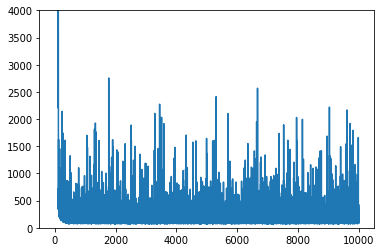

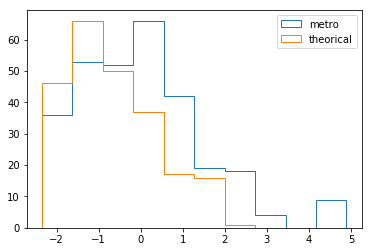

In [44]:
plt.plot(mean_sq_loss)
plt.ylim(0,4000)
plt.show()
#bk = np.concatenate((np.array([K]), sp_l_i))
#l = np.power(lagrange_multipliers-bk,2)
#print(l)
n, bins, _ = plt.hist(lagrange_multipliers[1:], histtype = 'step', label = 'metro')
plt.hist(sp_l_i, bins = bins, histtype = 'step', label = 'theorical')
plt.legend()
plt.show()
#gradients = np.array(gradients[-100:]).flatten()
#plt.hist(gradients)
#plt.show()

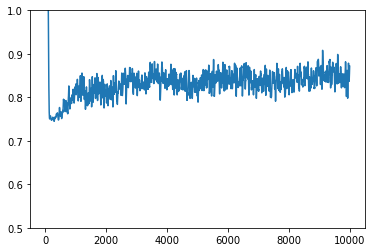

In [43]:
plt.plot(Ks)
#plt.axhline(K,label = 'K = %.2f'%K)
#plt.axhline(-K, color = 'red', label = '-K = %.2f'%-K)
#plt.legend()
plt.ylim(0.5,1)
plt.show()

## 6 - Max Ent 3

$ H = \sum_{i=1}^S \lambda_i x_i + \frac{1}{2}\sum_{i,j=1}^S M_{ij}x_i x_j$

$M_{ij}^{-1} = Cov(x_i,x_j)_{emp}$

$\lambda_i = - \sum_{j=1}^S M_{ij}x_j$

First of all we consider the matrix X of all the aboundances for all the subplots. It is a matrix of N rows and S columns.

In [28]:
X = cell_pop_M.reshape((200,299))

Then we compute for each species the mean and the standard deviation

In [29]:
x_mean = X.mean(axis = 0)
x_std = X.std(axis = 0)

We keep only those species that satisfy:

$<x_i>_{emp} - \sigma_{x_i} > 0$

In [30]:
aboundance_mask = x_mean - x_std > 0 
X_most_ab = X[:,aboundance_mask]

In this way we reduce the number of species from 299 to 52:

In [31]:
print(X_most_ab.shape[1])

52


Now we compute the inverse of the interaction matrix M as the covariance matrix of the abundances of the selected species and from that we obtain M inverting $M^{-1}$

In [32]:
inv_M = np.cov(X_most_ab.T)
M = np.linalg.inv(inv_M)

We now impose that the self interacting terms (diagonal) are null

In [33]:
mask = np.eye(M.shape[0]).astype('bool')
M[mask] = 0
print(M.trace())

0.0


In [34]:
print("Max interaction element: %.3f"%M.max())
print("Min interaction element: %.3f"%M.min())

Max interaction element: 0.176
Min interaction element: -0.093


At this point we can compute $\lambda_i$ with the formula reported at the begin of this section

In [35]:
X_most_mean = X_most_ab.mean(axis = 0)
lamb = -np.dot(M,X_most_mean)
#plt.hist(lamb)
#plt.show()
#plt.close()

# 7 - Analysis of the interaction network

In this first histogram we can see the distribuition of the entries of the matrix $M$. We can notice that the distribution is peaked around the zero (with a number of entries much higher than the length of the diagonal, i.e. ~600 vs 52) and it is more or less symmetric around zero.

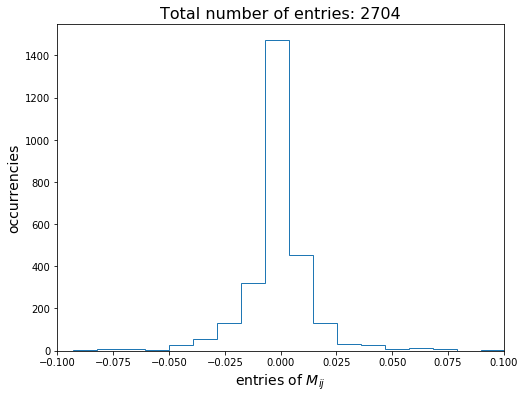

In [48]:
plt.figure(figsize = (8,6))
plt.hist(M.flatten(), bins = 25, histtype = 'step', density = False)
plt.xlim(-0.10, +0.10)
plt.xlabel("entries of $M_{ij}$", fontsize = 14)
plt.ylabel("occurrencies", fontsize = 14)
plt.title("Total number of entries: %d"%(len(M)**2), fontsize = 16)
plt.show()

Now we want to put a threshold $\theta$ on the absolute value of the entries of M. We choose as range for the threshold $[0,max(abs(M))]$

In [37]:
def laplacian(A):
    degrees = A.sum(axis = 0)
    K = np.diag(degrees)
    return K-A

In [38]:
# number of threshold we want to use
T = 2000
# consider evenly spaced thresholds
thresholds = np.linspace(0, np.max(np.abs(M)), T)
# placehholder for the number of connected components for each threshold
connected_components = np.zeros(T)
# this is the order of magnitude under which we consider zero an eigenvalue
sensibility = 10**-12 
#OBS: it can't be taken too small otherwise it would count 0 connected components for theta = 0, that is absurd

for i,theta in enumerate(thresholds):
    # elementwise boolean operation, returns a matrix of True and False
    threshold_mask = np.abs(M) > theta 
    # we can compute directly the adjacency matrix from the threshold mask
    A = threshold_mask.astype(int)
    # compute the laplacian of A
    L = laplacian(A)
    # eigenvalue decomposition; "eigh" used for symmetric matrix -> default format fo eigenvalues is set to float
    eig_values,V = np.linalg.eigh(L)
    # we take as zero all the eigenvalues with absolute value under the chosen sensibility 
    almost_zero = np.abs(eig_values) < sensibility
    # number of conncected components = number of zero eigenvalues (or equivalently degeneracy of eigval 0)
    connected_components[i] = np.count_nonzero(almost_zero.astype(int))

In [52]:
one_component_mask = connected_components == 1
theta_star = np.max(thresholds[one_component_mask])
print("Estimated theta star: %.4f"%theta_star)

Estimated theta star: 0.0031


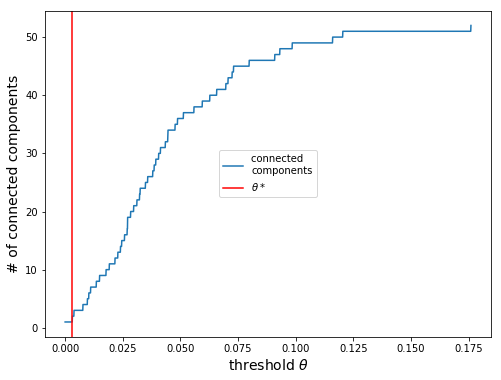

In [59]:
plt.figure(figsize = (8,6))
plt.plot(thresholds, connected_components, label = 'connected \ncomponents')
plt.xlabel("threshold "+r"$\theta$", fontsize = 14)
plt.ylabel("# of connected components", fontsize = 14)
plt.axvline(theta_star, color = 'red', label = r'$\theta*$')
plt.legend(loc = 'center')
plt.show()

In [41]:
# if we are interested in the detailed correspondence between threshold and connected components
for t,c in zip(thresholds, connected_components):
    print("Threshold = %.4f, connected components = %.d"%(t,c))

Threshold = 0.0000, connected components = 1
Threshold = 0.0001, connected components = 1
Threshold = 0.0002, connected components = 1
Threshold = 0.0003, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0004, connected components = 1
Threshold = 0.0005, connected components = 1
Threshold = 0.0006, connected components = 1
Threshold = 0.0007, connected components = 1
Threshold = 0.0008, connected components = 1
Threshold = 0.0009, connected components = 1
Threshold = 0.0010, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0011, connected components = 1
Threshold = 0.0012, connected components = 1
Threshold = 0.0013, connected components = 1
Threshold = 0.0014, connected components = 1
Threshold = 0.0015, connected components = 1
Threshold = 0.0016, connected components = 1
Threshold = 0.0017, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold = 0.0018, connected components = 1
Threshold 

Threshold = 0.1480, connected components = 51
Threshold = 0.1481, connected components = 51
Threshold = 0.1482, connected components = 51
Threshold = 0.1483, connected components = 51
Threshold = 0.1483, connected components = 51
Threshold = 0.1484, connected components = 51
Threshold = 0.1485, connected components = 51
Threshold = 0.1486, connected components = 51
Threshold = 0.1487, connected components = 51
Threshold = 0.1488, connected components = 51
Threshold = 0.1489, connected components = 51
Threshold = 0.1490, connected components = 51
Threshold = 0.1491, connected components = 51
Threshold = 0.1491, connected components = 51
Threshold = 0.1492, connected components = 51
Threshold = 0.1493, connected components = 51
Threshold = 0.1494, connected components = 51
Threshold = 0.1495, connected components = 51
Threshold = 0.1496, connected components = 51
Threshold = 0.1497, connected components = 51
Threshold = 0.1498, connected components = 51
Threshold = 0.1498, connected comp

In [42]:
import networkx as nx

In [43]:
threshold_mask = np.abs(M) > theta_star
# this is the adjacency matrix that we are going to use for our analysis
A_star = threshold_mask.astype(int)

Analyze the structural properties of W * (degree distribution, diameter, clustering, degree assortativity, betweeness centrality). In what respect, if any, the graph is different from a random ER graph?

Mean degree: 30.42
Degree standard deviation: 10.28


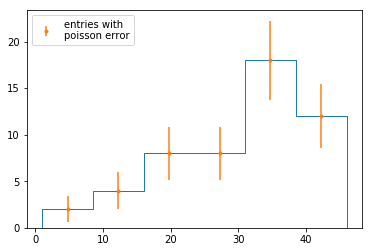

In [44]:
K = A_star.sum(axis = 0)
print("Mean degree: %.2f"% K.mean())
print("Degree standard deviation: %.2f"% K.std())
# not having much elements for a graphs we prefer to use a small amount of bins 
# in order to capture less information but more reliable
entries, bin_extremes, _ = plt.hist(K, bins = 6, histtype = 'step')
bin_centers = (bin_extremes[1:] + bin_extremes[:-1])/2
plt.errorbar(bin_centers, entries, yerr = np.sqrt(entries), fmt = '.', label = 'entries with \npoisson error')
plt.legend(loc = "upper left")
plt.show()

Using the networkx library we can easily compute most of the quantities of interest.

In [45]:
G = nx.from_numpy_matrix(A_star)

D = nx.diameter(G)
print("Diameter of the network: ", D)

# local clustering for each node
c_i_dict = nx.clustering(G)
n_nodes = len(G)
c_i = np.zeros(n_nodes)
for i in range(n_nodes):
    c_i[i] = c_i_dict[i]
    
# global clustering
C = c_i.mean()
print("Global clustering coefficient: %.2f"% C)

deg_assortativity = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: %.2f"%deg_assortativity)

btw_centrality = nx.betweenness_centrality(G)
b_c = np.zeros(n_nodes)
for i in range(n_nodes):
    b_c[i] = btw_centrality[i]
print("Max beetweenness centrality: %.2f"%b_c.max())

Diameter of the network:  3
Global clustering coefficient: 0.73
Degree assortativity: -0.24
Max beetweenness centrality: 0.05


We can compare these results with the one that we would find in an Erdosh-Reny graph with the same number of nodes and with probability of connecting two nodes given by $p = \frac{<k>}{n-1}$, where $<k>$ is the observed average degree of $A^*$. To do this, we consider an ensamble of E-R graphs in order to compute the estimated quantities and not the one of a single realization.

In [46]:
p = K.mean()/(n_nodes-1)
graphs_number = 100

# we are going to store in the following arrays all the results for each single ER graph 
# and then make a statistic out of them
ER_k_std_devs = np.zeros(graphs_number)
ER_diameters = np.zeros(graphs_number)
ER_cluster_coeffs = np.zeros(graphs_number)
ER_deg_assortativities = np.zeros(graphs_number)
ER_max_btw_centralities = np.zeros(graphs_number)


for i in range(graphs_number):
    # create an Erdosh-Reny graph
    ERG = nx.gnp_random_graph(n_nodes,p)
    # compute the degree standard deviation
    degs_dict = ERG.degree()
    degs = np.zeros(n_nodes)
    for j in range(n_nodes):
        degs[j] = degs_dict[j]
    ER_k_std_devs[i] = degs.std()
    
    ER_diameters[i] =  nx.diameter(ERG)
    
    c_i_dict = nx.clustering(ERG)
    c_i = np.zeros(n_nodes)
    for j in range(n_nodes):
        c_i[j] = c_i_dict[j]

    # global clustering
    ER_cluster_coeffs[i] = c_i.mean()

    ER_deg_assortativities[i] = nx.degree_assortativity_coefficient(ERG)

    btw_centrality = nx.betweenness_centrality(ERG)
    b_c = np.zeros(n_nodes)
    for j in range(n_nodes):
        b_c[j] = btw_centrality[j]
    ER_max_btw_centralities[i] = b_c.max()

print("Degree standard deviation: %.2f"% ER_k_std_devs.mean())
print("Diameter of the network: %.2f" % ER_diameters.mean())
print("Global clustering coefficient: %.2f"% ER_cluster_coeffs.mean())
print("Degree assortativity: %.2f"%ER_deg_assortativities.mean())
print("Max beetweenness centrality: %.2f"%ER_max_btw_centralities.mean())

Degree standard deviation: 3.37
Diameter of the network: 2.00
Global clustering coefficient: 0.60
Degree assortativity: -0.04
Max beetweenness centrality: 0.01


Confronting the results of the real network with the ensamble of ER graphs:

| Quantity | Real graph | ER graph|
| --- | --- | --- |
| degree std dev | 10.28 | 3.38 |
| diameter | 3 | 2.00 |
| clustering | 0.73| 0.59 |
| assortativity | -0.24 | -0.04 |
| max centrality | 0.05 | 0.01 |

We can see that none of these quantities is too similar between the two kinds of graphs. 

More precisely we can conclude that our network:
* presents a much higher variance in the degree distribution;
* has a larger diameter (ER diameter being 2.00 for a hundred graphs imply that none of them has diameter equal 3!);
* has a higher clustering coefficient;
* has a disassortative behaviour w.r.t. the almost neutral one of the ER ensamble;
* has a central node with a betweenness centrality that is 5 times higher than the "central" node of ER graphs.

All this suggests that the network of the species has an underlying structure that is not random, but possibly depends on the "microscopic" details of each species.

NOTE: ER results could vary a bit because we don't have a fixed seed for their generator.